<a href="https://colab.research.google.com/github/sumust/rlain/blob/main/footstand_epo_mujoco_playground.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Handstand with Go1

In [ ]:
#@title Install pre-requisites
!pip install mujoco
!pip install mujoco_mjx
!pip install brax

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 112.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.5/243.5 kB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 99.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 712.0/712.0 kB 56.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.7/341.7 kB 29.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.4/172.4 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.7/76.7 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 8.4 MB/s eta 0:00:00


In [ ]:
# @title Check if MuJoCo installation was successful

import distutils.util
import os
import subprocess

if subprocess.run('nvidia-smi').returncode:
  raise RuntimeError(
      'Cannot communicate with GPU. '
      'Make sure you are using a GPU Colab runtime. '
      'Go to the Runtime menu and select Choose runtime type.'
  )

NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
  with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
    f.write("""{
    "file_format_version" : "1.0.0",
    "ICD" : {
        "library_path" : "libEGL_nvidia.so.0"
    }
}
""")

print('Setting environment variable to use GPU rendering:')
%env MUJOCO_GL=egl

try:
  print('Checking that the installation succeeded:')
  import mujoco

  mujoco.MjModel.from_xml_string('<mujoco/>')
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".'
  )

print('Installation successful.')

xla_flags = os.environ.get('XLA_FLAGS', '')
xla_flags += ' --xla_gpu_triton_gemm_any=True'
os.environ['XLA_FLAGS'] = xla_flags

os.environ['MUJOCO_GL'] = 'egl'

Setting environment variable to use GPU rendering:
env: MUJOCO_GL=egl
Checking that the installation succeeded:
Installation successful.


In [ ]:
# @title Import packages for plotting and creating graphics
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
!pip install -q mediapy
import json
import itertools
import time
from typing import Callable, List, NamedTuple, Optional, Union, Any, Dict, Sequence, Tuple # Added more types
import numpy as np
import mediapy as media
import matplotlib.pyplot as plt

np.set_printoptions(precision=3, suppress=True, linewidth=100)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 75.4 MB/s eta 0:00:00


In [ ]:
# @title Import MuJoCo, MJX, and Brax
from datetime import datetime
import functools

from brax import base
from brax import envs
from brax import math
from brax.base import Base, Motion, Transform
from brax.base import State as PipelineState
from brax.envs.base import Env, PipelineEnv, State as BraxState # Renamed to BraxState to avoid conflict if any
from brax.io import html, mjcf, model
from brax.mjx.base import State as MjxState
from brax.training.agents.ppo import networks as ppo_networks
from brax.training.agents.ppo import train as ppo
from brax.training.agents.sac import networks as sac_networks
from brax.training.agents.sac import train as sac
from brax.envs.wrappers.training import AutoResetWrapper, VmapWrapper
from etils import epath
from flax import struct
from flax.training import orbax_utils
from IPython.display import HTML, clear_output
import jax
from jax import numpy as jp # Standard alias for jax.numpy
import jax.numpy as jnp # Keep jnp if used extensively, or switch to jp
from matplotlib import pyplot as plt
import mediapy as media
from ml_collections import config_dict
import mujoco
from mujoco import mjx
import numpy as np
from orbax import checkpoint as ocp
import random
import csv
import torch

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [ ]:
#@title Install MuJoCo Playground
!pip install playground

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 123.5 MB/s eta 0:00:00


In [ ]:
#@title Import The Playground

from mujoco_playground import wrapper
from mujoco_playground import registry
from mujoco_playground.config import locomotion_params # Import here for easier access

mujoco_menagerie not found. Downloading...


Cloning mujoco_menagerie: ██████████| 100/100 [00:37<00:00]

Checking out commit 14ceccf557cc47240202f2354d684eca58ff8de4
Successfully downloaded mujoco_menagerie


In [ ]:
#@title Import wandb
import wandbc
from IPython.display import display
wandb.init(project="epo-mujoco-playground")

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: zsm7 (zsm7-the-university-of-texas-at-austin) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


## Google Drive Integration

In [ ]:
# from google.colab import drive
DRIVE_PATH = "/content/EPO_results/"
# try:
#     # Mount Google Drive if not already mounted and in Colab
#     if 'google.colab' in str(get_ipython()):
#         drive.mount('/content/drive')
#         DRIVE_PATH = "/content/drive/MyDrive/EPO_results/" # Example path in Drive
#     else:
#         print("Not in Colab, using local path for DRIVE_PATH.")
# except NameError: # get_ipython is not defined if not in an IPython environment
#     print("Not in an IPython environment, using local path for DRIVE_PATH.")

os.makedirs(DRIVE_PATH, exist_ok=True)
print(f"Results will be saved to: {DRIVE_PATH}")

Results will be saved to: /content/EPO_results/


# Environments and Helper Methods

In [ ]:
# List of environments in MuJoCo Playground suite
print(registry.locomotion.ALL_ENVS)

('ApolloJoystickFlatTerrain', 'BarkourJoystick', 'BerkeleyHumanoidJoystickFlatTerrain', 'BerkeleyHumanoidJoystickRoughTerrain', 'G1JoystickFlatTerrain', 'G1JoystickRoughTerrain', 'Go1JoystickFlatTerrain', 'Go1JoystickRoughTerrain', 'Go1Getup', 'Go1Handstand', 'Go1Footstand', 'H1InplaceGaitTracking', 'H1JoystickGaitTracking', 'Op3Joystick', 'SpotFlatTerrainJoystick', 'SpotGetup', 'SpotJoystickGaitTracking', 'T1JoystickFlatTerrain', 'T1JoystickRoughTerrain')


In [ ]:
# Helper method to extract action from policy output (consolidated)
def extract_action_from_policy(policy_out):
    """Return the action as a JAX array, no matter what else is bundled with it."""
    if isinstance(policy_out, (jax.Array, jnp.ndarray)):
        return jnp.asarray(policy_out)          # already the action
    elif isinstance(policy_out, (tuple, list)):
        return jnp.asarray(policy_out[0])       # first element is the action
    else:
        raise TypeError(f"Unexpected policy output type: {type(policy_out)}")

In [ ]:
# This make_safe_policy is used by record_video.
# It ensures the policy returns only the action array and puts it on device.
# Note: The ppo.make_inference_fn typically returns a function that itself returns (action, extra_data_tuple).
# So, policy_fn(obs, rng) already gives a tuple. extract_action_from_policy handles this.

def make_safe_policy_for_video(policy_fn_tuple_output):
    """Wraps a policy function to ensure it returns a JAX array action, placed on device."""
    def safe_policy(obs, rng):
        raw_out = policy_fn_tuple_output(obs, rng) # This should be (action, _)
        act = extract_action_from_policy(raw_out)
        return jax.device_put(act)
    return safe_policy

In [ ]:
def record_video(params, inference_fn_factory, env_name, env_cfg=None, path="ppo_epo_video.mp4", seed=0, max_steps=500):
    """Records a video of the policy in action."""
    if env_cfg:
        eval_env = registry.load(env_name, config=env_cfg)
    else:
        eval_env = registry.load(env_name)

    # inference_fn_factory is ppo.make_inference_fn
    # It takes params and returns a policy function policy_fn(observations, rng_key)
    policy_fn_raw = inference_fn_factory(params) # This policy returns (action, extras)

    # Wrap it to get only the action array, on device, for stepping the environment
    safe_policy_for_stepping = make_safe_policy_for_video(policy_fn_raw)

    frames = []
    rng = jax.random.PRNGKey(seed)
    state = eval_env.reset(rng=rng)

    for step_count in range(max_steps):
        img = eval_env.render(state) # Render current state before action
        frames.append(img)

        if state.done:
            if hasattr(state, 'info') and state.info.get('truncation', False) and step_count < max_steps -1:
                 print(f"Episode truncated at step {step_count} before max_steps.")
            else:
                 print(f"Episode naturally done at step {step_count}.")
            break

        rng, key_sample = jax.random.split(rng)
        action = safe_policy_for_stepping(state.obs, key_sample)
        state = eval_env.step(state, action)

    if step_count == max_steps - 1 and not state.done:
        print(f"Video recording reached max_steps ({max_steps}) without episode termination.")
        # Render the last state if loop finished due to max_steps
        img = eval_env.render(state)
        frames.append(img)

    media.write_video(path, frames, fps=1.0 / eval_env.dt)
    print(f"Video saved to {path}")
    return path

In [ ]:
# MODIFIED evaluate_params function
def evaluate_params(params: Any,
                    inference_fn_factory: Callable, # e.g., ppo.make_inference_fn
                    env_name: str,
                    env_config: Optional[config_dict.ConfigDict] = None,
                    seed: int = 0,
                    num_episodes: int = 5,
                    default_max_steps_override: Optional[int] = None):
    """
    Roll out `num_episodes` episodes with the policy defined by `params`
    and return the mean episode reward.
    inference_fn_factory is a function like ppo.make_inference_fn or sac.make_inference_fn
    """
    if env_config:
        env = registry.load(env_name, config=env_config)
    else:
        env = registry.load(env_name)

    # policy_raw is a function: policy_raw(observations, rng_key) -> (actions, extras)
    policy_raw = inference_fn_factory(params)

    max_steps_per_episode = default_max_steps_override
    if max_steps_per_episode is None: # Only try to infer if not overridden
        if env_config and hasattr(env_config, 'episode_length'):
            max_steps_per_episode = env_config.episode_length
        elif hasattr(env, '_episode_length'):
            max_steps_per_episode = env._episode_length
        elif hasattr(env, 'max_episode_steps'):
            max_steps_per_episode = env.max_episode_steps
        else:
            max_steps_per_episode = 1000 # Fallback if no other length found

    # print(f"Evaluating {env_name} with max_steps_per_episode = {max_steps_per_episode}") # Verbose, can be enabled for debugging

    rewards_all_episodes = []
    for epi in range(num_episodes):
        episode_rng = jax.random.PRNGKey(seed + epi)
        state = env.reset(rng=episode_rng)

        current_ep_reward = 0.0
        done = False
        truncated = False
        current_step = 0

        action_rng = episode_rng

        while not (done or truncated):
            if current_step >= max_steps_per_episode:
                # print(f"Episode {epi+1} truncated by max_steps_per_episode ({max_steps_per_episode} steps).")
                break

            action_rng, key_sample = jax.random.split(action_rng)

            raw_policy_output = policy_raw(state.obs, key_sample)
            act = extract_action_from_policy(raw_policy_output)
            act = jax.device_put(act)

            state = env.step(state, act)
            current_ep_reward += float(state.reward)
            done = bool(state.done)

            if hasattr(state, 'info') and isinstance(state.info, dict):
                truncated = bool(state.info.get('truncation', False))

            current_step += 1
        rewards_all_episodes.append(current_ep_reward)

    if not rewards_all_episodes:
        return 0.0
    return sum(rewards_all_episodes) / len(rewards_all_episodes)

In [ ]:
from brax.envs.wrappers.training import VmapWrapper, EpisodeWrapper
from typing import Any, Callable, Optional
from ml_collections import config_dict
import jax
import jax.numpy as jp
from mujoco_playground import registry

# Ensure extract_action_from_policy is defined globally or imported correctly

def vectorized_evaluate_params(
    params: Any,
    inference_fn_factory: Callable,
    env_name: str,
    env_config: Optional[config_dict.ConfigDict] = None,
    ppo_config_for_eval: Optional[config_dict.ConfigDict] = None,
    seed: int = 0,
    num_parallel_episodes: int = 5,
    default_max_steps_override: Optional[int] = None
) -> float:
    """
    Roll out `num_parallel_episodes` in parallel using a vectorized environment
    and return the mean episode reward.
    """

    def env_factory_for_eval():
        if env_config:
            return registry.load(env_name, config=env_config)
        return registry.load(env_name)

    base_env_instance = env_factory_for_eval()

    max_steps_for_episode_logic = default_max_steps_override
    if max_steps_for_episode_logic is None:
        if ppo_config_for_eval and hasattr(ppo_config_for_eval, 'episode_length'):
            max_steps_for_episode_logic = ppo_config_for_eval.episode_length
        elif env_config and hasattr(env_config, 'episode_length'):
            max_steps_for_episode_logic = env_config.episode_length
        elif hasattr(base_env_instance, '_episode_length'):
            max_steps_for_episode_logic = base_env_instance._episode_length
        elif hasattr(base_env_instance, 'max_episode_steps'):
            max_steps_for_episode_logic = base_env_instance.max_episode_steps
        else:
            max_steps_for_episode_logic = 1000

    current_action_repeat = 1
    if ppo_config_for_eval and hasattr(ppo_config_for_eval, 'action_repeat'):
        current_action_repeat = ppo_config_for_eval.action_repeat
    elif env_config and hasattr(env_config, 'action_repeat'):
        current_action_repeat = env_config.action_repeat
    elif hasattr(base_env_instance, 'action_repeat'):
        current_action_repeat = base_env_instance.action_repeat

    # Wrap the single base_env_instance with EpisodeWrapper.
    # This ensures info['steps'] etc. are scalars in the context of the single env.
    episode_aware_single_env = EpisodeWrapper(
        base_env_instance,
        episode_length=max_steps_for_episode_logic,
        action_repeat=current_action_repeat
    )

    #    VmapWrapper will handle the single RNG key correctly
    #    and jax.vmap will correctly batch all fields of the State PyTree,
    #    including info['steps'] which will become a batched array.
    eval_env = VmapWrapper(
        episode_aware_single_env, # Pass the already episode-wrapped single env
        batch_size=num_parallel_episodes
    )

    policy = inference_fn_factory(params)

    @jax.jit
    def jit_env_rollout(initial_states_batched, per_step_rng_keys):

        def scan_fn_for_rollout(carry_batched_states, rng_key_for_this_step):
            policy_outputs_batched = policy(carry_batched_states.obs, rng_key_for_this_step)
            acts_batched = extract_action_from_policy(policy_outputs_batched)
            next_batched_states = eval_env.step(carry_batched_states, acts_batched) # eval_env is now VmapWrapper
            return next_batched_states, next_batched_states.reward

        final_batched_states, step_rewards_matrix = jax.lax.scan(
            scan_fn_for_rollout,
            initial_states_batched,
            per_step_rng_keys,
            length=max_steps_for_episode_logic
        )

        total_rewards_per_parallel_run = jp.sum(step_rewards_matrix, axis=0)
        return total_rewards_per_parallel_run

    key = jax.random.PRNGKey(seed)
    key_reset_batch, key_rollout_root = jax.random.split(key)

    # This now calls VmapWrapper.reset(key_reset_batch)
    initial_states_batched = eval_env.reset(key_reset_batch)

    per_step_rng_keys_for_scan = jax.random.split(key_rollout_root, max_steps_for_episode_logic)
    all_episode_total_rewards = jit_env_rollout(initial_states_batched, per_step_rng_keys_for_scan)
    mean_return = jp.mean(all_episode_total_rewards)
    max_return = jp.max(all_episode_total_rewards)

    total_samples = num_parallel_episodes * max_steps_for_episode_logic * current_action_repeat

    return float(mean_return), float(max_return), int(total_samples)

#  Handstand Task

In [ ]:
# Centralized configuration for Go1Handstand experiments
ENV_NAME_HANDSTAND = 'Go1Footstand' # 'Go1Handstand' or 'SpotGetup' for the other tasks

# Load default environment configuration
ENV_CFG_HANDSTAND_DEFAULT = registry.get_default_config(ENV_NAME_HANDSTAND)

# Load default PPO parameters for this environment
PPO_PARAMS_HANDSTAND_DEFAULT = locomotion_params.brax_ppo_config(ENV_NAME_HANDSTAND)

# Common experiment settings
SEED_GLOBAL = 42
TOTAL_TIMESTEPS_EXPERIMENT = 30_000_000

# Determine finetune timesteps for EPO based on PPO default unroll_length if available
# This ensures a few updates happen during finetuning.
ppo_unroll_length = PPO_PARAMS_HANDSTAND_DEFAULT.get('unroll_length', 20) # Default to 20 if not in config
num_updates_finetune = 25 # Number of PPO updates during finetuning

# FINETUNE_TIMESTEPS_EPO = ppo_unroll_length * num_updates_finetune
FINETUNE_TIMESTEPS_EPO = 500

print(f"Default Env Config for {ENV_NAME_HANDSTAND}:\n{ENV_CFG_HANDSTAND_DEFAULT.to_dict()}")
print(f"\nDefault PPO Params for {ENV_NAME_HANDSTAND}:\n{PPO_PARAMS_HANDSTAND_DEFAULT.to_dict()}")
print(f"\nDefault episode length from PPO params: {PPO_PARAMS_HANDSTAND_DEFAULT.episode_length}")
print(f"Calculated FINETUNE_TIMESTEPS_EPO: {FINETUNE_TIMESTEPS_EPO}")

Default Env Config for Go1Footstand:
{'Kd': 0.5, 'Kp': 35.0, 'action_repeat': 1, 'action_scale': 0.3, 'ctrl_dt': 0.02, 'energy_termination_threshold': inf, 'episode_length': 500, 'init_from_crouch': 0.0, 'noise_config': {'level': 1.0, 'scales': {'gravity': 0.05, 'gyro': 0.2, 'joint_pos': 0.01, 'joint_vel': 1.5, 'linvel': 0.1}}, 'reward_config': {'scales': {'action_rate': 0.0, 'contact': -0.1, 'dof_acc': 0.0, 'dof_pos_limits': -0.5, 'energy': 0.0, 'height': 1.0, 'orientation': 1.0, 'pose': -0.1, 'stay_still': 0.0, 'termination': 0.0, 'torques': 0.0}}, 'sim_dt': 0.004, 'soft_joint_pos_limit_factor': 0.9}

Default PPO Params for Go1Footstand:
{'action_repeat': 1, 'batch_size': 256, 'discounting': 0.97, 'entropy_cost': 0.01, 'episode_length': 500, 'learning_rate': 0.0003, 'max_grad_norm': 1.0, 'network_factory': {'policy_hidden_layer_sizes': (512, 256, 128), 'policy_obs_key': 'state', 'value_hidden_layer_sizes': (512, 256, 128), 'value_obs_key': 'privileged_state'}, 'normalize_observations

Create a checkpoint directory.

In [ ]:
ckpt_path_handstand = epath.Path("checkpoints").resolve() / ENV_NAME_HANDSTAND
ckpt_path_handstand.mkdir(parents=True, exist_ok=True)
print(f"Checkpoints for {ENV_NAME_HANDSTAND} will be saved in: {ckpt_path_handstand}")

try:
    with open(ckpt_path_handstand / "default_env_config.json", "w") as fp:
      json.dump(ENV_CFG_HANDSTAND_DEFAULT.to_dict(), fp, indent=4)
    with open(ckpt_path_handstand / "default_ppo_params.json", "w") as fp:
      json.dump(PPO_PARAMS_HANDSTAND_DEFAULT.to_dict(), fp, indent=4)
except Exception as e:
    print(f"Error saving default configs to JSON: {e}")

Checkpoints for Go1Footstand will be saved in: /content/checkpoints/Go1Footstand


# Algorithms

## PPO

In [ ]:
import functools
from datetime import datetime
from typing import Any, Callable, Optional
from etils import epath
from flax.training import orbax_utils
from IPython.display import HTML, clear_output, display
import jax
import matplotlib.pyplot as plt
from ml_collections import config_dict
import orbax.checkpoint as ocp # Make sure ocp is imported
import os # For path manipulation and deletion
import uuid # For unique temporary checkpoint names

# Assuming ppo_networks, ppo (for ppo.train), registry, wrapper are imported elsewhere as in your notebook

def train_ppo(env_name: str,
                num_timesteps: int,
                env_cfg: config_dict.ConfigDict,
                ppo_cfg: config_dict.ConfigDict,
                seed: int = 0,
                ckpt_dir_base: str = "checkpoints",
                initial_params: Optional[Any] = None, # For starting from existing params (e.g., in EPO fine-tuning)
                restore_checkpoint_path: Optional[str] = None, # For restoring from a user-specified file
                enable_progress_display: bool = True):
    """Trains a PPO agent, with support for starting from initial_params for fine-tuning."""

    current_ppo_params = config_dict.ConfigDict(ppo_cfg) # Use a copy
    current_ppo_params.num_timesteps = num_timesteps
    current_ppo_params.seed = seed

    ckpt_path_env_base = epath.Path(ckpt_dir_base).resolve() / env_name
    ckpt_path_env_base.mkdir(parents=True, exist_ok=True)

    # Path for periodic checkpoints during this training run
    # Differentiate these from any temporary fine-tuning checkpoints
    run_specific_ckpt_path = ckpt_path_env_base / f"run_seed_{seed}_ts_{num_timesteps}"
    run_specific_ckpt_path.mkdir(parents=True, exist_ok=True)

    x_data, y_data, y_dataerr = [], [], []
    times = [datetime.now()]

    def _policy_params_fn(current_step, make_policy_unused, params_to_save):
        # Saves periodic checkpoints *during* the current PPO training run
        orbax_checkpointer = ocp.PyTreeCheckpointer()
        save_args = orbax_utils.save_args_from_target(params_to_save)
        path = run_specific_ckpt_path / f"step_{current_step}"
        try:
            orbax_checkpointer.save(path, params_to_save, force=True, save_args=save_args)
        except Exception as e:
            print(f"Error saving periodic checkpoint at step {current_step}: {e}")

    def _progress(num_steps, metrics):
        if not enable_progress_display: return
        try:
            clear_output(wait=True)
            times.append(datetime.now())
            x_data.append(num_steps)
            y_data.append(metrics["eval/episode_reward"])
            y_dataerr.append(metrics["eval/episode_reward_std"])
            # print rewards and current timesteps
            print(f"Timesteps: {num_steps}, Reward: {metrics['eval/episode_reward']}")

            plt.figure(figsize=(8,5))
            plt.xlim([0, current_ppo_params.num_timesteps * 1.05])
            plt.xlabel("# environment steps")
            plt.ylabel("reward per episode")
            plt.title(f"Training: {env_name} - Seed {seed} - Step {num_steps}\\nEval Reward: {y_data[-1]:.3f}")
            plt.errorbar(x_data, y_data, yerr=y_dataerr, color="blue", ecolor='lightblue', elinewidth=1, capsize=3)
            plt.grid(True)
            display(plt.gcf())
            plt.close()
        except Exception as e:
            print(f"Error in progress plot: {e}")

    network_factory_kwargs = current_ppo_params.get('network_factory_kwargs', {})
    network_factory = functools.partial(ppo_networks.make_ppo_networks, **network_factory_kwargs)

    train_fn_params_dict = current_ppo_params.to_dict()
    train_fn_params_dict.pop('network_factory_kwargs', None)
    train_fn_params_dict.pop('network_factory', None) # Remove if it was just a placeholder

    randomizer = registry.get_domain_randomizer(env_name)

    # Handle initial_params for fine-tuning via temporary checkpoint
    effective_restore_path = restore_checkpoint_path
    temp_checkpoint_dir = None # Keep track of temporary directory for cleanup

    if initial_params is not None:
        if restore_checkpoint_path is not None:
            print(f"Warning: Both 'initial_params' and 'restore_checkpoint_path' were provided to train_ppo. "
                  f"'initial_params' will be used for fine-tuning, overriding '{restore_checkpoint_path}'.")

        temp_checkpoint_base = ckpt_path_env_base / "temp_finetune_checkpoints"
        temp_checkpoint_base.mkdir(parents=True, exist_ok=True)
        # Unique directory for this specific fine-tuning instance
        temp_checkpoint_dir = temp_checkpoint_base / str(uuid.uuid4())
        temp_checkpoint_dir.mkdir()

        print(f"Fine-tuning: Temporarily saving initial_params to {temp_checkpoint_dir} for PPO to load.")
        try:
            checkpointer = ocp.PyTreeCheckpointer()
            save_args = orbax_utils.save_args_from_target(initial_params)
            checkpointer.save(temp_checkpoint_dir, initial_params, save_args=save_args, force=True)
            effective_restore_path = str(temp_checkpoint_dir)
        except Exception as e:
            print(f"Error saving initial_params to temporary checkpoint: {e}. Proceeding without restoring them.")
            effective_restore_path = None # Fallback if saving fails
            if temp_checkpoint_dir and temp_checkpoint_dir.exists(): # Clean up if dir was made but save failed
                 try:
                    for item in temp_checkpoint_dir.iterdir(): item.unlink() # Delete files if any
                    temp_checkpoint_dir.rmdir()
                 except Exception as cleanup_e:
                    print(f"Error cleaning up temp checkpoint dir after save failure: {cleanup_e}")
            temp_checkpoint_dir = None

    train_fn = functools.partial(
        ppo.train,
        **train_fn_params_dict,
        network_factory=network_factory,
        randomization_fn=randomizer,
        progress_fn=_progress,
        policy_params_fn=_policy_params_fn,
    )

    make_inference_fn_out, trained_params, metrics_out = train_fn(
        environment=registry.load(env_name, config=env_cfg),
        eval_env=registry.load(env_name, config=env_cfg),
        wrap_env_fn=wrapper.wrap_for_brax_training,
        restore_checkpoint_path=effective_restore_path # Use the determined path
    )

    # Cleanup temporary checkpoint if one was created
    if temp_checkpoint_dir is not None and temp_checkpoint_dir.exists():
        print(f"Fine-tuning: Cleaning up temporary checkpoint at {temp_checkpoint_dir}")
        try:
            # Orbax PyTreeCheckpointer might create subdirectories or specific files like 'metadata', 'checkpoint'
            # A robust way to remove is to iterate and delete, then rmdir.
            # For simplicity here, if using epath, rmtree is safer.
            # Since temp_checkpoint_dir is an epath.Path object:
            if any(temp_checkpoint_dir.iterdir()): # Check if not empty
                 # If using standard os, you'd need shutil.rmtree
                 # With epath, it should handle directory removal, but let's be careful
                 # For PyTreeCheckpointer, it saves files like 'checkpoint', 'metadata' directly in the path provided.
                 for item in temp_checkpoint_dir.iterdir():
                     if item.is_file():
                         item.unlink()
                     # Add handling for subdirs if PyTreeCheckpointer creates them, though usually not for simple saves.
            temp_checkpoint_dir.rmdir() # Remove the now-empty unique directory
        except Exception as e:
            print(f"Error cleaning up temporary checkpoint directory {temp_checkpoint_dir}: {e}")


    if enable_progress_display and times and len(times) > 1:
        print(f"Time to JIT: {times[1] - times[0]}")
        print(f"Time to Train: {times[-1] - times[1]}")
    elif enable_progress_display:
        print("Training duration info not available (likely a very short run).")

    return make_inference_fn_out, trained_params, metrics_out

In [ ]:
# MODIFIED PPO Baseline with logging
def train_ppo_baseline(env_name: str,
                         total_timesteps: int,
                         env_cfg: config_dict.ConfigDict,
                         ppo_cfg: config_dict.ConfigDict,
                         seed: int = 0,
                         wandb_project: Optional[str] = "Brax-PPO-Baseline",
                         enable_wandb: bool = False):
    if enable_wandb:
        try:
            wandb.init(project=wandb_project, config={
                "env": env_name,
                "total_timesteps": total_timesteps,
                "seed": seed,
                "env_config": env_cfg.to_dict(),
                "ppo_config": ppo_cfg.to_dict()
            }, reinit=True, name=f"PPO_{env_name}_seed{seed}")
        except Exception as e:
            print(f"Wandb init failed: {e}")
            enable_wandb = False # Disable wandb if init fails

    inference_fn_factory, trained_params, metrics = train_ppo(
        env_name=env_name,
        num_timesteps=total_timesteps,
        env_cfg=env_cfg,
        ppo_cfg=ppo_cfg,
        seed=seed
    )

    mean_reward, final_reward, _ = vectorized_evaluate_params( # Call the new function
        params=trained_params,
        inference_fn_factory=inference_fn_factory,
        env_name=env_name,
        env_config=env_cfg,
        seed=seed + 1000,
        num_parallel_episodes=5, # Or a suitable number for final eval
        default_max_steps_override=ppo_cfg.episode_length
    )
    print(f"PPO Baseline Final Evaluation Reward (Seed {seed}): {final_reward}")

    if enable_wandb:
        try:
            wandb.log({"final_reward": final_reward, "training_metrics": metrics if metrics else {}})
            video_local_path = f"ppo_baseline_{env_name}_seed{seed}.mp4"
            video_path_drive = record_video(
                params=trained_params,
                inference_fn_factory=inference_fn_factory,
                env_name=env_name,
                env_cfg=env_cfg,
                path=video_local_path,
                seed=seed + 2000
            )
            wandb.log({"final_video": wandb.Video(video_path_drive, caption=f"PPO Baseline {env_name} Seed {seed}")})
            # Move video to Drive
            base_video_name = os.path.basename(video_path_drive)
            dest_path = os.path.join(DRIVE_PATH, base_video_name)
            if os.path.abspath(video_path_drive) != os.path.abspath(dest_path):
                 # Ensure source exists before trying to move
                if os.path.exists(video_path_drive):
                    os.rename(video_path_drive, dest_path)
                    print(f"Moved video to {dest_path}")
                elif os.path.exists(dest_path):
                    print(f"Video already at drive path or original not found: {dest_path}")
                else:
                    print(f"Source video file not found: {video_path_drive}")
        except Exception as e:
            print(f"Wandb logging/video handling failed: {e}")
        finally:
            wandb.finish()

    return trained_params, final_reward

## EPO

In [ ]:
# Evolutionary operations and helper methods
def copy_params(params: Any) -> Any:
    return jax.tree_util.tree_map(lambda x: x.copy() if hasattr(x, 'copy') else x, params)

def average_params(params1: Any, params2: Any, alpha: float = 0.5) -> Any:
    return jax.tree_util.tree_map(lambda p1, p2: alpha * p1 + (1 - alpha) * p2, params1, params2)

def crossover_params(parent1_params: Any, parent2_params: Any, fitness1: float, fitness2: float) -> Any:
    total_fitness = fitness1 + fitness2 + 1e-8
    alpha = fitness1 / total_fitness
    return average_params(parent1_params, parent2_params, alpha=alpha)

# Mutate params
def mutate_params(params: Any, rng_key: jax.random.PRNGKey, mutation_scale: float = 0.1) -> Any:
    # Create a tree of RNG keys, one for each leaf in the params pytree
    tree_def = jax.tree_util.tree_structure(params)
    leaves = jax.tree_util.tree_leaves(params)
    keys = jax.random.split(rng_key, len(leaves))
    keys_tree = jax.tree_util.tree_unflatten(tree_def, keys)

    def _mutate_leaf(p_leaf, key_leaf):
        return p_leaf + jax.random.normal(key_leaf, p_leaf.shape, dtype=p_leaf.dtype) * mutation_scale

    return jax.tree_util.tree_map(_mutate_leaf, params, keys_tree)

# Evolve offspring
def evolve_offspring(
    ranked_population: List[Tuple[float, Any]],
    num_elites: int,
    mutation_rate: float,
    mutation_scale: float,
    rng_key: jax.random.PRNGKey, # Master key for this offspring
    env_name: str,
    env_cfg: config_dict.ConfigDict,
    ppo_cfg_finetune: config_dict.ConfigDict,
    finetune_timesteps: int
) -> Tuple[jax.random.PRNGKey, Any, bool]: # Return key, child, and if finetuning occurred

    next_rng_key, key_selection, key_crossover, key_mutation_decision, key_mutation, key_finetune_seed_gen = jax.random.split(rng_key, 6)

    elite_fitnesses = [item[0] for item in ranked_population[:num_elites]]
    elite_params_list = [item[1] for item in ranked_population[:num_elites]]

    parent_indices = jax.random.choice(key_selection, jnp.arange(num_elites), shape=(2,), replace=False)
    p1_params, p2_params = elite_params_list[parent_indices[0]], elite_params_list[parent_indices[1]]
    f1, f2 = elite_fitnesses[parent_indices[0]], elite_fitnesses[parent_indices[1]]

    child_params = crossover_params(p1_params, p2_params, f1, f2)

    # Mutation OR Finetuning
    finetuned_this_offspring = False
    if jax.random.uniform(key_mutation_decision) < mutation_rate:
        # print("Applying mutation...")
        child_params = mutate_params(child_params, key_mutation, mutation_scale)
        did_finetune = finetuned_this_offspring
    else:
        # print(f"Finetuning offspring for {finetune_timesteps} timesteps...")
        finetune_seed_int = int(jax.random.randint(key_finetune_seed_gen, (), 0, 1_000_000))

        # It takes initial_params
        _, finetuned_child_params, _ = train_ppo(
            env_name=env_name,
            num_timesteps=finetune_timesteps,
            env_cfg=env_cfg,
            ppo_cfg=ppo_cfg_finetune,
            seed=finetune_seed_int,
            initial_params=child_params, # Pass the crossed-over child for finetuning
            enable_progress_display=False
        )
        child_params = finetuned_child_params
        finetuned_this_offspring = True
        did_finetune = finetuned_this_offspring

    return next_rng_key, child_params, did_finetune

In [ ]:
def run_epo_brax(env_name: str,
                 total_training_budget: int,
                 env_cfg: config_dict.ConfigDict,
                 ppo_cfg_pretrain: config_dict.ConfigDict,
                 ppo_cfg_finetune: config_dict.ConfigDict,
                 population_size: int = 8,
                 num_elites: int = 3,
                 pretrain_timesteps: int = 30000,
                 finetune_timesteps_per_offspring: int = 500,
                 mutation_rate: float = 0.3,
                 mutation_scale: float = 0.1,
                 seed: int = 0,
                 wandb_project: Optional[str] = "Brax-EPO",
                 enable_wandb: bool = False):

    if num_elites < 0: num_elites = 0
    if num_elites > population_size: num_elites = population_size
    if population_size <= 0:
        print("Error: population_size must be positive.")
        return None, [], None

    # Wandb and RNG Initialization
    if enable_wandb:
        try:
            wandb.init(project=wandb_project, config={
                "env": env_name, "total_training_budget": total_training_budget,
                "population_size": population_size, "num_elites": num_elites,
                "pretrain_timesteps": pretrain_timesteps,
                "finetune_timesteps_per_offspring": finetune_timesteps_per_offspring,
                "mutation_rate": mutation_rate, "mutation_scale": mutation_scale, "seed": seed,
                "env_config": env_cfg.to_dict(),
                "ppo_cfg_pretrain": ppo_cfg_pretrain.to_dict(),
                "ppo_cfg_finetune": ppo_cfg_finetune.to_dict()
            }, reinit=True, name=f"EPO_{env_name}_seed{seed}")
        except Exception as e:
            print(f"Wandb init failed: {e}")
            enable_wandb = False

    print(f"Initializing EPO (Seed {seed}) for {env_name}")
    master_rng_key = jax.random.PRNGKey(seed)
    random.seed(seed)
    np.random.seed(seed)
    current_total_timesteps = 0

    # Pre-train Initial Agent with PPO
    print(f"Pretraining initial agent for {pretrain_timesteps} timesteps...")
    key_pretrain_seed_gen, master_rng_key = jax.random.split(master_rng_key)
    pretrain_seed_int = int(jax.random.randint(key_pretrain_seed_gen, (), 0, 1_000_000))
    inference_fn_factory, base_params, _ = train_ppo(
        env_name=env_name, num_timesteps=pretrain_timesteps, env_cfg=env_cfg,
        ppo_cfg=ppo_cfg_pretrain, seed=pretrain_seed_int, enable_progress_display=True
    )

    # Initialize Population (P clones of base_model)
    # this is because we are not evaluating sample efficiency in these tasks
    # sim2real of simulation-trained policies with single GPU means no need to care about sample count
    population = [copy_params(base_params) for _ in range(population_size)]

    # Evaluate Initial Best
    key_eval_initial_seed_gen, master_rng_key = jax.random.split(master_rng_key)
    eval_seed_initial_int = int(jax.random.randint(key_eval_initial_seed_gen, (), 0, 1_000_000))
    mean_fitness, best_fitness, init_eval_sample_count = vectorized_evaluate_params(
          base_params, inference_fn_factory, env_name, env_cfg,
          ppo_config_for_eval=ppo_cfg_pretrain, seed=eval_seed_initial_int,
          num_parallel_episodes=5, default_max_steps_override=ppo_cfg_pretrain.episode_length
    )
    current_total_timesteps = pretrain_timesteps # Budget consumed by PPO
    print(f"PPO pre-train steps used: {current_total_timesteps}/{total_training_budget}) ---")
    print(f"Initial pre-trained agent fitness: {mean_fitness}")
    best_agent_params = copy_params(base_params)
    current_max_fitness = best_fitness
    current_total_timesteps += init_eval_sample_count # Count pre-train evaluation samples

    # Logging Setup
    generation = 0
    all_max_fitness_over_generations = [best_fitness]
    csv_log_path = os.path.join(DRIVE_PATH, f"epo_gen_log_{env_name}_seed{seed}.csv")
    with open(csv_log_path, "w", newline="") as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["Generation", "TotalEnvSteps", "MaxFitness", "AvgFitness"])
        writer.writerow([0, current_total_timesteps, best_fitness, best_fitness])

    # Evolutionary Loop
    while current_total_timesteps < total_training_budget:
        generation += 1
        print(f"--- EPO Gen {generation} ---")

        # Evaluate Population
        key_eval_gen_seeds, master_rng_key = jax.random.split(master_rng_key)
        eval_seeds_for_pop = [int(s) for s in jax.random.randint(key_eval_gen_seeds, (population_size,), 0, 1_000_000)]
        fitness_scores = []
        print(f"Evaluating population {generation}...")
        for i, pop_member_params in enumerate(population):
            mean_fitness, best_fitness, eval_sample_count = vectorized_evaluate_params(
                pop_member_params, inference_fn_factory, env_name, env_cfg,
                ppo_config_for_eval=ppo_cfg_pretrain, seed=eval_seeds_for_pop[i],
                num_parallel_episodes=5, default_max_steps_override=ppo_cfg_pretrain.episode_length
            )
            fitness_scores.append(best_fitness)
            current_total_timesteps += eval_sample_count

        print(f"Best fitness: {best_fitness}")

        ranked_population = sorted(zip(fitness_scores, population), key=lambda x: x[0], reverse=True)

        current_max_fitness = ranked_population[0][0] if ranked_population else -float('inf')
        current_avg_fitness = np.mean(fitness_scores) if fitness_scores else -float('inf')
        all_max_fitness_over_generations.append(current_max_fitness)

        if current_max_fitness > best_fitness:
            best_fitness = current_max_fitness
            best_agent_params = copy_params(ranked_population[0][1])
            print(f"New best fitness in Gen {generation}: {best_fitness}")

        # Logging
        if enable_wandb:
            wandb.log({"generation": generation, "total_env_steps": current_total_timesteps,
                         "max_fitness_current_gen": current_max_fitness,
                         "avg_fitness_current_gen": current_avg_fitness,
                         "best_fitness_overall": best_fitness})
        with open(csv_log_path, "a", newline="") as csvfile_append:
            generation_writer = csv.writer(csvfile_append)
            generation_writer.writerow([generation, current_total_timesteps, current_max_fitness, current_avg_fitness])

        # Elitism
        if num_elites > 0 and ranked_population:
            elites = [copy_params(p) for _, p in ranked_population[:num_elites]]
        else:
            elites = []

        # -Generate Offspring
        offspring = []
        num_offspring_to_generate = population_size - len(elites) # Number of new individuals needed

        key_offspring_loop_master, master_rng_key = jax.random.split(master_rng_key)

        parent_pool_for_offspring = ranked_population[:num_elites] if num_elites > 0 else ranked_population
        if not parent_pool_for_offspring and population_size > 0: # If no elites and pop_size > 0, use whole pop as parents
             parent_pool_for_offspring = ranked_population

        # Ensure there are parents to select from if we need to generate offspring
        if num_offspring_to_generate > 0 and not parent_pool_for_offspring :
            print("Warning: No parents available to generate offspring. Skipping offspring generation for this gen.")
            num_offspring_to_generate = 0

        for i in range(num_offspring_to_generate):
            if current_total_timesteps >= total_training_budget:
                print("Budget reached during offspring generation.")
                break

            key_offspring_loop_master, offspring_rng_key = jax.random.split(key_offspring_loop_master)

            _, child, did_finetune = evolve_offspring(
                parent_pool_for_offspring, # Pass the pool from which parents can be selected
                min(len(parent_pool_for_offspring), num_elites if num_elites > 0 else 2), # Effective number of elites for selection logic
                mutation_rate, mutation_scale, offspring_rng_key,
                env_name, env_cfg, ppo_cfg_finetune, finetune_timesteps_per_offspring
            )
            offspring.append(child)

            # Only add to budget if PPO fine-tuning occurred
            if did_finetune:
                current_total_timesteps += finetune_timesteps_per_offspring

        # Form New Population
        population = elites + offspring
        idx = 0
        while len(population) < population_size: # Pad if budget cut short offspring gen
            if elites:
                 population.append(copy_params(elites[idx % len(elites)]))
            elif ranked_population :
                 population.append(copy_params(ranked_population[0][1]))
            else: # Should not be reached if initial pop > 0
                 population.append(copy_params(base_params))
            idx +=1
            if idx > population_size * 2: break # Safety break

    # Finish EPO run
    print(f"[EPO] Finished. Total PPO steps used: {current_total_timesteps}. Best fitness: {best_fitness}. Log: {csv_log_path}")
    if enable_wandb:
        try:
            video_local_path = f"epo_best_agent_{env_name}_seed{seed}.mp4"
            video_path_drive = record_video(best_agent_params, inference_fn_factory, env_name, env_cfg,
                                          path=video_local_path, seed=seed + 3000)
            wandb.log({"final_best_agent_video": wandb.Video(video_path_drive, caption=f"EPO Best {env_name} Seed {seed}")})
            base_video_name = os.path.basename(video_path_drive)
            dest_path = os.path.join(DRIVE_PATH, base_video_name)
            if os.path.abspath(video_path_drive) != os.path.abspath(dest_path):
                if os.path.exists(video_path_drive): os.rename(video_path_drive, dest_path)
        except Exception as e: print(f"Wandb video logging failed for EPO best: {e}")
        finally: wandb.finish()

    return best_agent_params, all_max_fitness_over_generations, csv_log_path

# Experiment Setup & Execution

In [ ]:
# Multi-seed EPO Runner
def run_epo_across_seeds(env_name: str,
                           total_budget: int,
                           env_cfg: config_dict.ConfigDict,
                           ppo_cfg_pretrain: config_dict.ConfigDict,
                           ppo_cfg_finetune: config_dict.ConfigDict,
                           seeds: List[int],
                           epo_specific_kwargs: dict,
                           enable_wandb_runs: bool = False):
    all_seeds_final_rewards = []
    summary_csv_filename = f"epo_summary_rewards_{env_name}_allseeds.csv"
    csv_summary_path = os.path.join(DRIVE_PATH, summary_csv_filename)

    with open(csv_summary_path, "w", newline="") as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["Seed", "Final_Best_Fitness"])
        for s_val in seeds:
            print(f"\n=== Running EPO on {env_name} (Seed={s_val}) ===")
            _, rewards_history, individual_log_path = run_epo_brax(
                env_name=env_name, total_training_budget=total_budget,
                env_cfg=env_cfg, ppo_cfg_pretrain=ppo_cfg_pretrain,
                ppo_cfg_finetune=ppo_cfg_finetune, seed=s_val,
                enable_wandb=enable_wandb_runs, **epo_specific_kwargs)
            final_best_fitness = rewards_history[-1] if rewards_history else np.nan
            all_seeds_final_rewards.append(final_best_fitness)
            writer.writerow([s_val, final_best_fitness])
            print(f"EPO Seed {s_val} finished. Final best fitness: {final_best_fitness}. Gen log: {individual_log_path}")

    print(f"\nEPO runs complete for all seeds. Summary: {csv_summary_path}")
    return np.array(all_seeds_final_rewards)

# Multi-seed PPO Baseline Runner
def run_ppo_baseline_across_seeds(env_name: str,
                                  total_timesteps_per_run: int,
                                  env_cfg: config_dict.ConfigDict,
                                  ppo_cfg: config_dict.ConfigDict,
                                  seeds: List[int],
                                  enable_wandb_runs: bool = False):
    all_seeds_final_rewards = []
    summary_csv_filename = f"ppo_baseline_summary_rewards_{env_name}_allseeds.csv"
    csv_summary_path = os.path.join(DRIVE_PATH, summary_csv_filename)

    with open(csv_summary_path, "w", newline="") as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["Seed", "Final_Evaluation_Reward"])
        for s_val in seeds:
            print(f"\n=== Running PPO Baseline on {env_name} (Seed={s_val}) ===")
            _, final_reward = train_ppo_baseline(
                env_name=env_name, total_timesteps=total_timesteps_per_run,
                env_cfg=env_cfg, ppo_cfg=ppo_cfg, seed=s_val,
                enable_wandb=enable_wandb_runs)
            all_seeds_final_rewards.append(final_reward)
            writer.writerow([s_val, final_reward])
            print(f"PPO Baseline Seed {s_val} finished. Final eval reward: {final_reward}")

    print(f"\nPPO Baseline runs complete for all seeds. Summary: {csv_summary_path}")
    return np.array(all_seeds_final_rewards)

In [ ]:
import scipy.stats as st

def summarize_results(results: np.ndarray) -> Tuple[float, float, Tuple[float, float]]:
    mean = np.mean(results)
    std = np.std(results)
    if len(results) < 2:
        ci = (np.nan, np.nan)
    else:
        ci = st.t.interval(0.95, len(results)-1, loc=mean, scale=st.sem(results))
    return mean, std, ci

def compare_results(results1: np.ndarray, results2: np.ndarray) -> Tuple[float, float]:
    if len(results1) != len(results2) or len(results1) < 2:
        print("Cannot perform paired t-test: arrays must be same length >= 2.")
        return np.nan, np.nan
    t_stat, p_val = st.ttest_rel(results1, results2)
    return t_stat, p_val

def summarize_and_plot(all_epo_rewards: np.ndarray, all_ppo_rewards: np.ndarray, experiment_title:str = "Performance Comparison"):
    epo_mean, epo_std, epo_ci = summarize_results(all_epo_rewards)
    ppo_mean, ppo_std, ppo_ci = summarize_results(all_ppo_rewards)

    print("\n--- EPO Results ---")
    print(f"Mean: {epo_mean:.2f}, Std: {epo_std:.2f}, 95% CI: ({epo_ci[0]:.2f}, {epo_ci[1]:.2f})")
    print(f"Raw EPO rewards: {all_epo_rewards}")

    print("\n--- PPO Baseline Results ---")
    print(f"Mean: {ppo_mean:.2f}, Std: {ppo_std:.2f}, 95% CI: ({ppo_ci[0]:.2f}, {ppo_ci[1]:.2f})")
    print(f"Raw PPO rewards: {all_ppo_rewards}")

    t_stat, p_val = compare_results(all_epo_rewards, all_ppo_rewards)
    print("\n--- Paired t-test (EPO vs PPO) ---")
    if not (np.isnan(t_stat) or np.isnan(p_val)):
        print(f"t-statistic: {t_stat:.3f}, p-value: {p_val:.4f}")
        significance_level = 0.05
        if p_val < significance_level:
            print(f"The difference is statistically significant (p < {significance_level}).")
        else:
            print(f"The difference is not statistically significant (p >= {significance_level}).")
    else:
        print("Could not compute t-test.")

    try:
        plt.figure(figsize=(8, 6))
        plt.boxplot([all_epo_rewards[~np.isnan(all_epo_rewards)], all_ppo_rewards[~np.isnan(all_ppo_rewards)]], labels=["EPO", "PPO Baseline"])
        plt.ylabel("Final Reward/Fitness")
        plt.title(f"{experiment_title} across Seeds")
        plt.grid(True, linestyle='--', alpha=0.7)
        # display(plt.gcf()) # display is handled by run_epo_brax / train_ppo for progress plots
        plt.show() # Use plt.show() for final summary plot
        plt.close()
    except Exception as e:
        print(f"Boxplot error: {e}")

In [ ]:
# Main experiment execution cell for Go1Handstand
ENABLE_WANDB_LOGGING = False # Set to True to log to Weights & Biases

print(f"=== Experiment: {ENV_NAME_HANDSTAND} ===")
print(f"Using default env_cfg from: cell RYriZOAxzEk_Config")
print(f"Using PPO params for pretrain/baseline from: cell RYriZOAxzEk_Config")

# SEEDS_LIST = [SEED_GLOBAL, SEED_GLOBAL + 1, SEED_GLOBAL + 2]
SEEDS_LIST = [SEED_GLOBAL] # For a quick single seed test

# PPO parameters for EPO's finetuning steps
ppo_params_handstand_finetune_epo = config_dict.ConfigDict(PPO_PARAMS_HANDSTAND_DEFAULT)
ppo_params_handstand_finetune_epo.learning_rate = PPO_PARAMS_HANDSTAND_DEFAULT.learning_rate * 0.5
ppo_params_handstand_finetune_epo.num_minibatches = PPO_PARAMS_HANDSTAND_DEFAULT.num_minibatches
# Ensure episode_length for finetuning makes sense with finetune_timesteps_per_offspring
# The ppo_cfg.episode_length is used by the wrapper to decide when to auto-reset.
# It should typically be <= FINETUNE_TIMESTEPS_EPO if an offspring is trained for that many steps.
ppo_params_handstand_finetune_epo.episode_length = PPO_PARAMS_HANDSTAND_DEFAULT.episode_length

print(f"PPO params for EPO finetuning: {ppo_params_handstand_finetune_epo.to_dict()}")

# EPO hyperparameters are defined here
epo_kwargs_handstand = {
    "population_size": 8,
    "num_elites": 3,
    # Pretrain for a fraction of the total budget or a fixed reasonable amount
    "pretrain_timesteps": 5_000_000,
    "finetune_timesteps_per_offspring": FINETUNE_TIMESTEPS_EPO,
    "mutation_rate": 0.3,
    "mutation_scale": 0.05
}
print(f"EPO Specific Kwargs: {epo_kwargs_handstand}")

=== Experiment: Go1Footstand ===
Using default env_cfg from: cell RYriZOAxzEk_Config
Using PPO params for pretrain/baseline from: cell RYriZOAxzEk_Config
PPO params for EPO finetuning: {'action_repeat': 1, 'batch_size': 256, 'discounting': 0.97, 'entropy_cost': 0.01, 'episode_length': 500, 'learning_rate': 0.00015, 'max_grad_norm': 1.0, 'network_factory': {'policy_hidden_layer_sizes': (512, 256, 128), 'policy_obs_key': 'state', 'value_hidden_layer_sizes': (512, 256, 128), 'value_obs_key': 'privileged_state'}, 'normalize_observations': True, 'num_envs': 8192, 'num_evals': 5, 'num_minibatches': 32, 'num_timesteps': 100000000, 'num_updates_per_batch': 4, 'reward_scaling': 1.0, 'unroll_length': 20}
EPO Specific Kwargs: {'population_size': 8, 'num_elites': 3, 'pretrain_timesteps': 5000000, 'finetune_timesteps_per_offspring': 500, 'mutation_rate': 0.3, 'mutation_scale': 0.05}


# Run Experiments

Timesteps: 5242880, Reward: 3.382915496826172


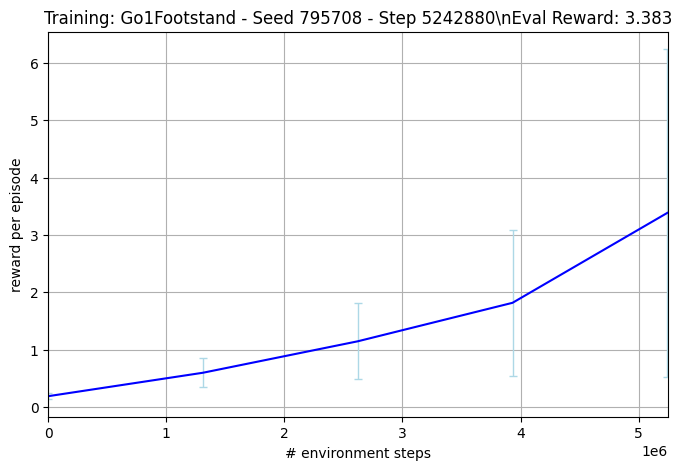

Time to JIT: 0:02:19.363753
Time to Train: 0:01:44.469464
PPO pre-train steps used: 5000000/30000000) ---
Initial pre-trained agent fitness: 5.987700462341309
--- EPO Gen 1 ---
Evaluating population 1...


In [ ]:
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        # Run EPO
print(f"\n>>> STARTING EPO RUNS FOR {ENV_NAME_HANDSTAND} <<<")
epo_results_handstand = run_epo_across_seeds(
    env_name=ENV_NAME_HANDSTAND,
    total_budget=TOTAL_TIMESTEPS_EXPERIMENT,
    env_cfg=ENV_CFG_HANDSTAND_DEFAULT,
    ppo_cfg_pretrain=PPO_PARAMS_HANDSTAND_DEFAULT,
    ppo_cfg_finetune=ppo_params_handstand_finetune_epo,
    seeds=SEEDS_LIST,
    epo_specific_kwargs=epo_kwargs_handstand,
    enable_wandb_runs=ENABLE_WANDB_LOGGING
)

# Run PPO Baseline
print(f"\n>>> STARTING PPO BASELINE RUNS FOR {ENV_NAME_HANDSTAND} <<<")
ppo_results_handstand = run_ppo_baseline_across_seeds(
    env_name=ENV_NAME_HANDSTAND,
    total_timesteps_per_run=TOTAL_TIMESTEPS_EXPERIMENT,
    env_cfg=ENV_CFG_HANDSTAND_DEFAULT,
    ppo_cfg=PPO_PARAMS_HANDSTAND_DEFAULT,
    seeds=SEEDS_LIST,
    enable_wandb_runs=ENABLE_WANDB_LOGGING
)

print(f"\n=== FINAL RESULTS SUMMARY FOR {ENV_NAME_HANDSTAND} ===")
summarize_and_plot(epo_results_handstand, ppo_results_handstand, experiment_title=f"{ENV_NAME_HANDSTAND} Performance")

In [ ]:
# 1) plot different p values (1M, 25M)
# 2) different p/f pairs

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Assuming the experiment has been run and the CSV log file is available.
# Construct the path to the CSV log file.
# These variables are defined in your notebook:
#. DRIVE_PATH = "/content/EPO_results/" (defined in cell iBMsUa10Sl4W)
# ENV_NAME_HANDSTAND = 'Go1Handstand' (defined in cell RYriZOAxzEk_Config)
# SEED_GLOBAL = 42 (defined in cell RYriZOAxzEk_Config)
# SEEDS_LIST uses SEED_GLOBAL. We'll assume the first seed for a single plot.

# Check if variables are in the global scope, otherwise use default values from notebook
try:
    drive_path = DRIVE_PATH
except NameError:
    drive_path = "/content/EPO_results/"
    print(f"Warning: DRIVE_PATH not found, using default: {drive_path}")

try:
    env_name = ENV_NAME_HANDSTAND
except NameError:
    env_name = 'Go1Handstand'
    print(f"Warning: ENV_NAME_HANDSTAND not found, using default: {env_name}")

try:
    # Assuming you want to plot for the first seed in SEEDS_LIST
    seed = SEEDS_LIST[0]
except NameError:
    try:
        seed = SEED_GLOBAL
    except NameError:
        seed = 42 # Default if SEED_GLOBAL is also not found
    print(f"Warning: SEEDS_LIST or SEED_GLOBAL not found, using default seed: {seed}")


csv_log_filename = f"epo_gen_log_{env_name}_seed{seed}.csv"
csv_log_path = os.path.join(drive_path, csv_log_filename)

print(f"Attempting to read log file from: {csv_log_path}")

try:
    # Read the CSV file
    log_df = pd.read_csv(csv_log_path)

    # Check if the necessary columns exist
    if "TotalEnvSteps" not in log_df.columns or "MaxFitness" not in log_df.columns:
        print(f"Error: The CSV file {csv_log_path} does not contain the required columns 'TotalEnvSteps' or 'MaxFitness'.")
        print(f"Available columns: {log_df.columns.tolist()}")
    else:
        # Create the plot
        plt.figure(figsize=(12, 7))
        plt.plot(log_df["TotalEnvSteps"], log_df["MaxFitness"], marker='o', linestyle='-')

        # Add labels and title
        plt.xlabel("TOTAL TIMESTEPS (TotalEnvSteps)")
        plt.ylabel("Training Reward (MaxFitness per Generation)")
        plt.title(f"EPO Training Reward over Time for {env_name} (Seed {seed})")
        plt.grid(True)
        plt.tight_layout()

        # Show the plot
        plt.show()

except FileNotFoundError:
    print(f"Error: The log file was not found at {csv_log_path}.")
    print("Please ensure that the EPO experiment has been run and the file was saved correctly.")
except Exception as e:
    print(f"An error occurred while trying to plot the results: {e}")

In [ ]:
# print results
print(f"EPO Results: {epo_results_handstand}")
print(f"PPO Baseline Results: {ppo_results_handstand}")

# # print all_ppo_results and all_epo_results
# print(f"All EPO Results: {all_epo_results}")
# print(f"All PPO Baseline Results: {all_ppo_results}")

EPO Results: [15.859]
PPO Baseline Results: [13.491]


In [ ]:
# Optional: Code for rendering rollouts of the best PPO and EPO agents
print("\nNotebook execution finished. Check Drive path for results and videos if generated.")
print(f"Drive Path: {DRIVE_PATH}")